In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

rankings = pd.read_csv("FIFA Rankings From 1993 To 2022/fifa_ranking_1993_2022.csv")
rankings = rankings.loc[:,["rank", "country_full", "country_abrv", "cur_year_avg_weighted", "rank_date", "last_year_avg_weighted",
                           "two_year_ago_weighted", "three_year_ago_weighted"]]
rankings = rankings.replace({"IR Iran": "Iran", "USA": "United States", "Korea Republic": "South Korea"})
rankings["weighted_points"] =  rankings["cur_year_avg_weighted"] + rankings["last_year_avg_weighted"] + rankings["two_year_ago_weighted"] + rankings["three_year_ago_weighted"]
rankings["rank_date"] = pd.to_datetime(rankings["rank_date"])

matches = pd.read_csv("International Results From 1872 To 2022/results.csv")
matches =  matches.replace({"Germany DR": "Germany", "China": "China PR", "Ivory Coast": "Côte d'Ivoire", "Eswatini": "Swaziland"})
matches["date"] = pd.to_datetime(matches["date"])

world_cup = pd.read_csv("Datasets/World Cup 2022 Dataset.csv")
world_cup = world_cup.loc[:, ["Team", "Group", "First Match Against", "Second Match Against", "Third Match Against"]]
world_cup = world_cup.dropna(how="all")
world_cup = world_cup.set_index("Team")

In [2]:
# I want to have the ranks for every day 
rankings = rankings.set_index(["rank_date"])\
            .groupby(["country_full"], group_keys=False)\
            .resample("D").first()\
            .fillna(method="ffill")\
            .reset_index()

# join the ranks
matches = matches.merge(rankings, 
                        left_on=["date", "home_team"], 
                        right_on=["rank_date", "country_full"])
matches = matches.merge(rankings, 
                        left_on=["date", "away_team"], 
                        right_on=["rank_date", "country_full"], 
                        suffixes=("_home", "_away"))

In [3]:
# feature generation
matches["rank_difference"] = matches["rank_home"] - matches["rank_away"]
matches["average_rank"] = (matches["rank_home"] + matches["rank_away"])/2
matches["point_difference"] = matches["weighted_points_home"] - matches["weighted_points_away"]
matches["score_difference"] = matches["home_score"] - matches["away_score"]
matches["is_won"] = matches["score_difference"] > 0 # take draw as lost
matches["is_stake"] = matches["tournament"] != "Friendly"


C:\Users\guinj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


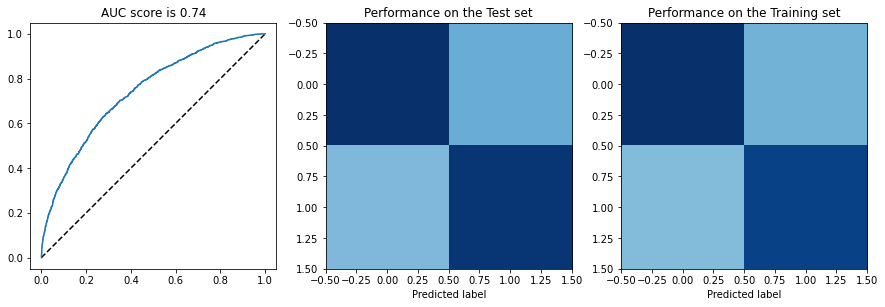

In [4]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = matches.loc[:,["average_rank", "rank_difference", "point_difference", "is_stake"]], matches["is_won"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ("polynomial_features", features),
    ("logistic_regression", logreg)
])
model = model.fit(X_train, y_train)

# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], "k--")
ax.plot(fpr, tpr)
ax.set_title("AUC score is {0:0.2}".format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap="Blues", clim = (0, cm.max())) 

ax.set_xlabel("Predicted label")
ax.set_title("Performance on the Test set")

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap="Blues", clim = (0, cm.max())) 
ax.set_xlabel("Predicted label")
ax.set_title("Performance on the Training set")
pass

Stakes distribution in the wrong predictions
True     0.571429
False    0.428571
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.637646
False    0.362354
Name: is_stake, dtype: float64


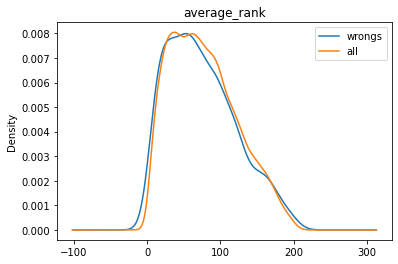

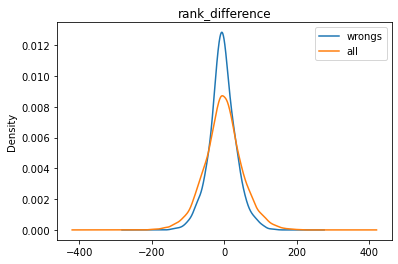

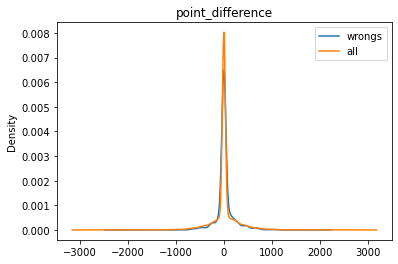

In [5]:
features = ["average_rank", "rank_difference", "point_difference"]
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(["wrongs", "all"])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, "is_stake"].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X["is_stake"].value_counts() / X.shape[0])

# World Cup simulation

## Group rounds

In [6]:
# let's define a small margin when we safer to predict draw then win
margin = 0.05

# let's define the rankings at the time of the World Cup
world_cup_rankings = rankings.loc[(rankings["rank_date"] == rankings["rank_date"].max()) & 
                                    rankings["country_full"].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(["country_full"])

In [8]:
from itertools import combinations

opponents = ["First Match Against", "Second Match Against", "Third Match Against"]

world_cup["points"] = 0
world_cup["total_prob"] = 0

for group in set(world_cup["Group"]):
    print("___Starting group {}:___".format(group))
    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, "rank"]
        home_points = world_cup_rankings.loc[home, "weighted_points"]
        opp_rank = world_cup_rankings.loc[away, "rank"]
        opp_points = world_cup_rankings.loc[away, "weighted_points"]
        row["average_rank"] = (home_rank + opp_rank) / 2
        row["rank_difference"] = home_rank - opp_rank
        row["point_difference"] = home_points - opp_points
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        world_cup.loc[home, "total_prob"] += home_win_prob
        world_cup.loc[away, "total_prob"] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, "points"] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, "points"] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, "points"] += 1
            world_cup.loc[away, "points"] += 1

___Starting group A:___
Qatar vs. Ecuador: Draw
Qatar vs. Senegal: Senegal wins with 0.70
Qatar vs. Netherlands: Netherlands wins with 0.78
Ecuador vs. Senegal: Senegal wins with 0.68
Ecuador vs. Netherlands: Netherlands wins with 0.77
Senegal vs. Netherlands: Netherlands wins with 0.60
___Starting group F:___
Belgium vs. Canada: Belgium wins with 0.73
Belgium vs. Morocco: Belgium wins with 0.71
Belgium vs. Croatia: Belgium wins with 0.67
Canada vs. Morocco: Morocco wins with 0.63
Canada vs. Croatia: Croatia wins with 0.75
Morocco vs. Croatia: Croatia wins with 0.64
___Starting group G:___
Brazil vs. Serbia: Brazil wins with 0.71
Brazil vs. Switzerland: Brazil wins with 0.66
Brazil vs. Cameroon: Brazil wins with 0.73
Serbia vs. Switzerland: Switzerland wins with 0.62
Serbia vs. Cameroon: Serbia wins with 0.58
Switzerland vs. Cameroon: Switzerland wins with 0.65
___Starting group D:___
France vs. Australia: France wins with 0.72
France vs. Denmark: France wins with 0.62
France vs. Tunis

## Single-elimination rounds

In [9]:
pairing = [0,3,4,7,8,11,12,15,2,1,6,5,10,9,14,13]

world_cup = world_cup.sort_values(by=["Group", "points", "total_prob"], ascending=False).reset_index()
next_round_wc = world_cup.groupby("Group").nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index("Team")

finals = ["round_of_16", "quarterfinal", "semifinal", "final"]

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, "rank"]
        home_points = world_cup_rankings.loc[home, "weighted_points"]
        opp_rank = world_cup_rankings.loc[away, "rank"]
        opp_points = world_cup_rankings.loc[away, "weighted_points"]
        row["average_rank"] = (home_rank + opp_rank) / 2
        row["rank_difference"] = home_rank - opp_rank
        row["point_difference"] = home_points - opp_points

        home_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, "country_abrv"], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, "country_abrv"], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Netherlands vs. United States: Netherlands wins with probability 0.54
Argentina vs. Denmark: Argentina wins with probability 0.58
Spain vs. Croatia: Spain wins with probability 0.56
Brazil vs. Uruguay: Brazil wins with probability 0.66
England vs. Senegal: England wins with probability 0.64
France vs. Mexico: France wins with probability 0.63
Belgium vs. Germany: Belgium wins with probability 0.66
Portugal vs. Switzerland: Portugal wins with probability 0.55


___Starting of the quarterfinal___
Netherlands vs. Argentina: Argentina wins with probability 0.59
Spain vs. Brazil: Brazil wins with probability 0.65
England vs. France: France wins with probability 0.56
Belgium vs. Portugal: Belgium wins with probability 0.64


___Starting of the semifinal___
Argentina vs. Brazil: Brazil wins with probability 0.61
France vs. Belgium: Belgium wins with probability 0.55


___Starting of the final___
Brazil vs. Belgium: Belgium wins with probability 0.52


